In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import os
from sklearn.feature_extraction import DictVectorizer
import scipy.sparse as sp

test = pd.read_csv(os.path.join('data', 'test_users.csv'), header=0, parse_dates=[1,2,3])
train = pd.read_csv(os.path.join('data', 'train_users_2.csv'), header=0, parse_dates=[1,2,3])
df_sessions = pd.read_csv("data/sessions.csv", encoding='utf8')

Taking care of Train + Test Users 

In [2]:
#encoding country destinations in train set
outcome = train.country_destination
labels = outcome.values
le = LabelEncoder()
y = le.fit_transform(labels)
train = train.drop(['country_destination'], axis=1)

#storing user ids in test set
id_test = test['id']

#appending test to train and dropping date first booking which is redundant
data = pd.concat((train, test), axis=0, ignore_index=True)
data = data.drop(['date_first_booking'], axis=1)

#extracting features from date_account_created
data['dac_year'] = data.date_account_created.apply(lambda x: x.year)
data['dac_month'] = data.date_account_created.apply(lambda x: x.month)
data['dac_weekday'] = data.date_account_created.apply(lambda x: x.weekday())
data = data.drop(['date_account_created'], axis=1)

#extracting features from timestamp_first_active
data['tfa_year'] = data.timestamp_first_active.apply(lambda x: x.year)
data['tfa_month'] = data.timestamp_first_active.apply(lambda x: x.month)
data['tfa_weekday'] = data.timestamp_first_active.apply(lambda x: x.weekday())
data = data.drop(['timestamp_first_active'], axis=1)

#filling age nan with age median
data.age = data.age.fillna(data.age.median())

#binning age column 
bins = list(np.arange(15, 85, 5))
bins.insert(0,0)
bins.append(int(max(data.age)))
group_names = ['<15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', 
               '50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '>80']
data['age_bucket'] = pd.cut(data['age'], bins, labels=group_names)

#cleaning gender column and filling nan in all dataframe with 'unknown' 
data.gender = data.gender.replace('-unknown-','unknown')
data.ix[:, data.columns != 'age_bucket'] = data.ix[:, data.columns != 'age_bucket'].fillna('unknown')

#generating dummy variables in top of categorical columns
to_be_dummified = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser','age_bucket']
for f in to_be_dummified:
    dummies = pd.get_dummies(data[f], prefix=f)
    data = data.drop([f], axis=1)
    data = pd.concat((data, dummies), axis=1)

Taking care of Sessions

In [3]:
# Drop row with nan values from the "user_id" column as they're useless
df_sessions = df_sessions.dropna(subset=["user_id"])

# Frequency of devices - by user
device_freq = df_sessions.groupby('user_id').device_type.value_counts()

# Frequency of actions taken - by user
action_freq = df_sessions.groupby('user_id').action.value_counts()

# Total list of users
users = data.id

def feature_dict(df):
    f_dict = dict(list(df.groupby(level='user_id')))
    res = {}
    for k, v in f_dict.items():
        v.index = v.index.droplevel('user_id')
        res[k] = v.to_dict()
    return res

# Make a dictionary with the frequencies { 'user_id' : {"IPhone": 2, "Windows": 1}}
action_dict = feature_dict(action_freq)
device_dict = feature_dict(device_freq)

# Transform to a list of dictionaries
action_rows = [action_dict.get(k, {}) for k in users]
device_rows = [device_dict.get(k, {}) for k in users]

device_transf = DictVectorizer()
tf = device_transf.fit_transform(device_rows)

action_transf = DictVectorizer()
tf2 = action_transf.fit_transform(action_rows)

# Concatenate the two datasets
# Those are row vectors with the frequencies of both device and actions [0, 0, 0, 2, 0, 1, ...]
features = sp.hstack([tf, tf2])

# We create a dataframe with the new features and we write it to disk
df_sess_features = pd.DataFrame(features.todense())
df_sess_features['id'] = users

In [4]:
del df_sessions # Cleanup

Joining Train + Test Users with Session Information

In [5]:
#left joining data and sessions on user_id
final = pd.merge(data, df_sess_features, how='left', left_on='id', right_on='id')
final.ix[:, final.columns != 'age_bucket'].fillna(-1, inplace=True)

# Using inplace because I have 8GB of RAM
# final.ix[:, final.columns != 'age_bucket'] = final.ix[:, final.columns != 'age_bucket'].fillna(-1)

final.drop(['id'], axis=1, inplace=True)


Running Model

In [15]:
from mylib.scoring import ndcg_at_k

def mean_ndcg(clf, X, y):
    # Predict class probabilities
    y_predict = clf.predict_proba(X)
    # Get highest 5 predictions
    best_5 = np.argsort(-y_predict, axis=1)[:, :5]
    
    # Transform to relevance scores
    relevance = (best_5 == y[:, np.newaxis]).astype('int')
    
    # Calculate ndcg for each sample and take average (?)
    return np.mean([ndcg_at_k(row, 5) for row in relevance])

In [ ]:
X = final[:train.shape[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n_trees = [10, 20, 40, 80, 160]
df = pd.DataFrame(np.nan, index=n_trees, columns=['train_score', 'test_score', 'ndcg_score'])
for n in n_trees:
    clf = RandomForestClassifier(n_estimators=n, oob_score=True, n_jobs=-1)
    clf = clf.fit(X_train, y_train)
    
    # The RF will give you unusually high training error if calculated this way
    # http://stats.stackexchange.com/questions/66543/random-forest-is-overfitting
    
    # Changing to out-of-bag error
    df.loc[[n],'train_score'] = clf.oob_score_
    df.loc[[n],'test_score'] = clf.score(X_test, y_test)
    df.loc[[n],'ndcg_score'] = mean_ndcg(clf, X_test, y_test)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


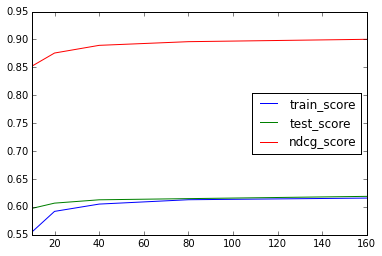

In [12]:
import matplotlib.pyplot as plt
%pylab inline
df.plot.line()
plt.show()

In [13]:
df

,train_score,test_score,ndcg_score
10,0.555422,0.597425,0.852547
20,0.591964,0.606752,0.875748
40,0.605047,0.612729,0.889522
80,0.612858,0.614816,0.896109
160,0.615808,0.618890,0.900342


In [12]:
#y_pred = clf.predict_proba(data[train.shape[0]:])  

In [13]:
#ids = []  #list of ids
#cts = []  #list of countries
#for i in range(len(id_test)):
#    idx = id_test[i]
#    ids += [idx] * 5
#    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
#sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
#sub.to_csv(os.path.join('data', 'sub.csv'),index=False)

In [16]:
from sklearn.grid_search import GridSearchCV

In [18]:
# Feature selection, we run random forest and we remove some less-useful features
# to improve performance
clf = RandomForestClassifier(n_estimators=160, oob_score=True, n_jobs=1)

# use a full grid over all parameters
param_grid = {"max_depth": [6, 3, None],
              "max_features": ["sqrt", 'log2', 0.5, 0.1],
#               "min_samples_split": [2],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

search = GridSearchCV(clf, param_grid, scoring=mean_ndcg)


In [ ]:
X = final[:train.shape[0]]
search.fit(X, y)